# Interaction Prediction

*State of the Interactomes: an evaluation of molecular networks for generating biological insights.* Wright, SN et al. [https://doi.org/10.1101/2024.04.26.587073]  
This notebook contains code and results related to:
* Figure 5A-D
* EV Figure 6A-H

**Note: due to the size of network data sets utilized in this study, this notebook draws on summarized results rather than re-evaluating all networks directly.**

For implementation of the interaction prediction algorithms, see `ExampleUsage/IP_InteractionPrediction.README.md`


In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neteval.network_statistics import NetworkStats, load_network_names
from neteval.community_annotation import *
from tqdm import tqdm
import os
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import itertools
from goatools.semantic import semantic_similarity
from collections import defaultdict
from neteval.gsea_functions import *
import obonet as obo
from goatools.obo_parser import GODag
from neteval.data_import_export_tools import *

In [47]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25


In [48]:
gitdir = os.path.dirname(os.getcwd())
figdir = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Figures/')
evaldir = os.path.join(gitdir, 'Data/example_outputs/')
datadir = os.path.join(gitdir, 'Data/')
network_names = load_network_names(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/network_names_final.txt'))
example_names = load_network_names(os.path.join(gitdir, 'Data/example_network_names.txt'))

## Example Analysis

See `Network_Evaluation_Tools/ExampleUsage/InteractionPrediction.README.md` for usage of prediction functionalities.  


## Figures 5A-C - Interaction Prediction Precision

Load the prediction results from Dataset EV3

See FigEV4A/B for interactomes excluded due to circularity with CORUM and PANTHER. 

In [49]:
pred_results = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/DatasetEV3.txt'), sep='\t')

In [50]:
import warnings

def compare_prediction_methods(pred_results, test_set, palette, net_order=None, ax=None, top_n=None, exclude_nets=[] ):
    plot_df = pred_results[pred_results['Test Set']==test_set]
    # keep only interactome with results for both prediction methods
    method_counts = plot_df.groupby('Interactome')['Prediction Method'].nunique()
    exclude_nets += method_counts[method_counts < 2].index.values.tolist()
    plot_df = plot_df[~plot_df.Interactome.isin(exclude_nets)]
    if net_order is None:
        net_order = plot_df.Interactome.unique()[::-1]
    if type(net_order) == str:
        if net_order in plot_df.columns:
            net_order = plot_df.groupby('Interactome')[net_order].mean().sort_values(ascending=False).index
    if ax is None:
        _, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 8))
    
    if top_n is not None:
        plot_df = plot_df[plot_df['Interactome'].isin(net_order[:top_n])]
        net_order=net_order[:top_n]
        
    if test_set == 'Held-out':
        #plot strip plot
        plot_df = plot_df.reset_index(drop=True)
        sns.stripplot(data = plot_df, y='Interactome', x='P@k', ax=ax, hue='Prediction Method', dodge=False, s=3, 
                      order=net_order, jitter=False, edgecolor='black', linewidth=0.25, alpha=0.5,  
                      hue_order=['MPS', 'L3'], palette=palette)
        sns.pointplot(data = plot_df, y='Interactome', x='P@k', ax=ax, hue='Prediction Method', dodge=False,
                      order=net_order, linestyle='none', errorbar=None, marker='|', markersize=6,  
                      hue_order=['MPS', 'L3'], palette=palette)
        # add horizontal lines between y ticks
        for i in range(len(net_order)):
            ax.hlines(i+0.5, 0, 1, color='grey', linewidth=0.25)
        ax.set_ylim(len(net_order)-0.5, -0.5)
        
    else:
        #plot bar plots
        plot_df = plot_df.reset_index(drop=True)
        sns.barplot(data=plot_df, y='Interactome', x='P@k', ax=ax, hue='Prediction Method', order=net_order, 
                    hue_order=['MPS', 'L3'], alpha=1, errorbar=None, edgecolor='black', 
                    linewidth=0.25, palette=palette, saturation=1)
    return net_order
    
    

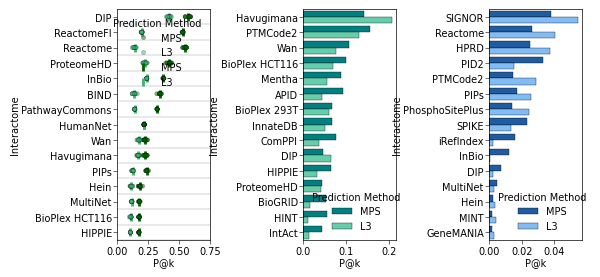

In [51]:

_, [ax1, ax2, ax3] = plt.subplots(ncols=3, nrows=1, figsize=(6, 3), gridspec_kw={'wspace': 1})
_ = compare_prediction_methods(pred_results, test_set='Held-out', net_order='P@k', ax=ax1, 
                           palette=['darkgreen', 'mediumseagreen'], top_n=15)
ax1.set_xlim(0, 0.75)

_ = compare_prediction_methods(pred_results, test_set='CORUM', net_order='P@k', ax=ax2, 
                           palette=['teal', 'mediumaquamarine'], top_n=15, 
            exclude_nets=[ 'ReactomeFI','PathwayCommons', 'GeneMANIA', 'ConsensusPathDB', 'iRefIndex'])

_ = compare_prediction_methods(pred_results, test_set='PANTHER', net_order='P@k', ax=ax3, 
                           palette=['#1f5ca1', '#82bcf5'], top_n=15, 
            exclude_nets=[ 'ReactomeFI','PathwayCommons'])

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore deprecation warning
    plt.savefig(os.path.join(figdir, 'Fig5ABC_interaction_prediction_Pk.jpg'))

Get statistics for the top performing networks

In [52]:
pred_means = pred_results.groupby(['Test Set', 'Prediction Method', 'Interactome'])['P@k'].mean().sort_values(ascending=False)

In [53]:
pred_means['Held-out'].head(5)

Prediction Method  Interactome
MPS                DIP            0.572754
                   Reactome       0.546134
                   ReactomeFI     0.527650
                   ProteomeHD     0.417894
L3                 DIP            0.416756
Name: P@k, dtype: float64

In [54]:
pred_means['CORUM'].head(5)

Prediction Method  Interactome
L3                 Havugimana     0.207153
MPS                PTMCode2       0.155445
                   Havugimana     0.142955
L3                 PTMCode2       0.129673
MPS                Wan            0.105902
Name: P@k, dtype: float64

In [55]:
pred_means['PANTHER'].head(5)

Prediction Method  Interactome
L3                 SIGNOR         0.054782
                   Reactome       0.040512
MPS                SIGNOR         0.038402
L3                 HPRD           0.037319
MPS                PID2           0.033224
Name: P@k, dtype: float64

## Figure 5D - Network Coverage of Predicted Interactions

Assess the presence of predicted interactomes in other networks

In [56]:
coverage_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig5D_interaction_coverage_revised.csv'))

In [57]:
coverage_df['weighted_mean'] = coverage_df.apply(lambda x: (x['1'] + (2)*x['2-5'] + 6*x['6-10'] + 11*x['11-20'] + 21*x['21+'])/x['k'], axis=1)

In [58]:
def plot_coverage_stats(coverage_df, ax=None, order=None, **kwargs):
    coverage_stats =coverage_df.drop_duplicates(subset=['network']).set_index('Name')
    stack_data = coverage_stats.groupby(['Name']).mean(numeric_only=True).loc[:, ('0', '1', '2-5', '6-10', '11-20', '21+', 'weighted_mean')].dropna()
    return_order=False
    if order is None:
        #order=list(stack_data.sort_values(by=['21+', '11-20', '6-10', '2-5', '1'], ascending=False).sort_values('0').index)
        order=list(stack_data.sort_values(by=['weighted_mean'], ascending=False).index)
        return_order=True
    if ax is None:
        _ = plt.figure(figsize=(10, 2))
        ax= plt.gca()
    stack_data.drop(columns='weighted_mean').loc[order].plot(kind='bar', stacked=True, edgecolor='black', ax=ax, 
                            color=['#b8de29', '#73d055', '#29af7f', '#238a8d', '#33638d', 'darkslateblue'][::-1], **kwargs)
    if return_order:
        return order
    else:
        return stack_data


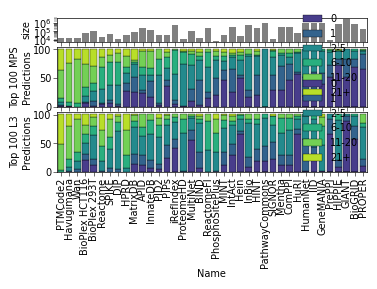

In [59]:
_, [ax3, ax1, ax2] = plt.subplots(nrows=3, ncols=1, figsize=(4, 2), sharex=True, gridspec_kw={'hspace':0.1, 'height_ratios':[0.4, 1, 1]})

order_list = plot_coverage_stats(coverage_df[coverage_df.method=='MPS'], ax=ax1, width=0.8, use_index=True, order=None)
x = plot_coverage_stats(coverage_df[coverage_df.method=='L3'], ax=ax2, order=order_list, width=0.8, use_index=True)
# get x order from ax2
sns.barplot(coverage_df[coverage_df.method=='L3'].groupby('Name')['size'].mean(numeric_only=True).loc[order_list], ax=ax3, color='grey')
ax1.set_ylabel('Top 100 MPS\nPredictions')
ax2.set_ylabel('Top 100 L3\nPredictions')
ax3.set_yscale('log')

## Supplemental Figures

### EV4A-B  - CORUM/PANTHER Overlap

Examine the proportion of external interactions that are already present in each interactome


External set sizes:
* **CORUM** = 41034
* **PANTHER** = 24238

In [60]:
overlap_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data', 'FigEV4_corum_panther_overlap.txt'), sep='\t', index_col=0)

<AxesSubplot: xlabel='%PANTHER', ylabel='Count'>

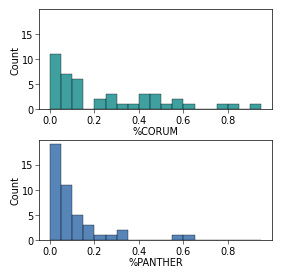

In [61]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(3,3), sharey=True, gridspec_kw={'hspace':0.3})
sns.histplot(overlap_df, x='%CORUM', ax=ax1, bins=[i/100 for i in range(0, 100, 5)], color='teal')
sns.histplot(overlap_df, x='%PANTHER', ax=ax2, bins=[i/100 for i in range(0, 100, 5)], color='#1f5ca1')

In [62]:
overlap_df.sort_values('%CORUM', ascending=False).head()

,CORUM Interactions,PANTHER Interactions,%CORUM,%PANTHER
PathwayCommons,40538,24154,0.987912,0.996534
ConsensusPathDB,38679,5361,0.942609,0.221182
STRING,33404,14750,0.814057,0.608549
FunCoup,32336,4441,0.788029,0.183225
InBio,24698,4802,0.601891,0.198119


### EV4C-D - CORUM/PANTHER Overlap vs Performance

Does the performance in predicting these external sets correlate with the overlap?

In [63]:
# exclude interactomes that directly incorporate the external data sets
exclude_corum = ['ReactomeFI', 'PathwayCommons', 'GeneMANIA', 'ConsensusPathDB', 'iRefIndex']
exclude_panther=['ReactomeFI', 'PathwayCommons']

P@k    %CORUM
Test Set                           
CORUM    P@k     1.000000  0.084231
         %CORUM  0.084231  1.000000
Held-out P@k     1.000000 -0.060976
         %CORUM -0.060976  1.000000
PANTHER  P@k     1.000000 -0.324213
         %CORUM -0.324213  1.000000

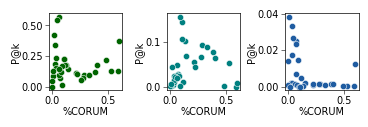

In [64]:
corum_df = pred_results[(pred_results['Prediction Method'] == 'MPS') & (~pred_results.Interactome.isin(exclude_corum))].groupby(['Interactome', 'Test Set'])['P@k'].mean().reset_index()
_, axs = plt.subplots(1, 3, figsize=(4, 1), gridspec_kw={'wspace':0.6})
colors=['#006400', '#008080', '#1f5ca1'] 
plot_df = corum_df.join(overlap_df, on='Interactome')
for i, test_set in enumerate(['Held-out', 'CORUM', 'PANTHER']):
    sns.scatterplot(plot_df[plot_df['Test Set']==test_set], x='%CORUM', y='P@k', ax = axs[i], s=20, color=colors[i])
plot_df.groupby('Test Set')[['P@k', '%CORUM']].corr()                                                                                        

P@k  %PANTHER
Test Set                             
CORUM    P@k       1.000000 -0.266053
         %PANTHER -0.266053  1.000000
Held-out P@k       1.000000 -0.080607
         %PANTHER -0.080607  1.000000
PANTHER  P@k       1.000000 -0.009243
         %PANTHER -0.009243  1.000000

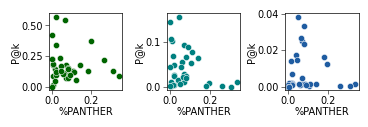

In [65]:
panther_df = pred_results[(pred_results['Prediction Method'] == 'MPS') & (~pred_results.Interactome.isin(exclude_panther))].groupby(['Interactome', 'Test Set'])['P@k'].mean().reset_index()
_, axs = plt.subplots(1, 3, figsize=(4, 1), gridspec_kw={'wspace':0.6})
colors=['#006400', '#008080', '#1f5ca1'] 
for i, test_set in enumerate(['Held-out', 'CORUM', 'PANTHER']):
    plot_df = panther_df.join(overlap_df, on='Interactome')
    sns.scatterplot(plot_df[plot_df['Test Set']==test_set], x='%PANTHER', y='P@k', ax = axs[i], s=20, color=colors[i])
plot_df.groupby('Test Set')[['P@k', '%PANTHER']].corr()

### EV4E - Hierarchical community sizes

For implementation of HiDeF, see `Supplemental_Code/HiDeF_README.md`

In [66]:
# load the previously computed assemblies
complex_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigEV4EFGH_complex_prediciton.csv'), index_col=0)

In [67]:
def plot_stacked_bar(df, bin_edges,order=None, ax=None):
    """
    Plots a stacked bar graph showing the distribution of cluster sizes per network.

    Parameters:
    df (pd.DataFrame): DataFrame with 'Network' and 'Cluster_size' columns.
    bin_edges (list): List of bin edges for binning the 'Cluster_size'.
    """
    
    # Create a column 'Bin' that assigns each row to a bin based on 'Cluster_size'
    df['Bin'] = pd.cut(df['Cluster_size'], bins=bin_edges, include_lowest=True)
    col_order = df.sort_values(by='Bin').Bin.unique()
    # Count the number of instances per network and per bin
    bin_counts = df.groupby(['Network', 'Bin']).size().unstack(fill_value=0)
    bin_counts = bin_counts.loc[:, col_order]
    # Plotting the stacked bar chart
    if order is not None:
        bin_counts.loc[order].plot(kind='bar', stacked=True, colormap='Blues_r', ax=ax)
        df.Network.value_counts().loc[order].plot(kind='bar', ax=ax, edgecolor='black', fill=None)
    else:
        bin_counts.plot(kind='bar', stacked=True, colormap='Blues_r', ax=ax)
        df.Network.value_counts().plot(kind='bar', ax=ax, edgecolor='black', fill=None)
    
    # Adding labels and title
    plt.xlabel('Network')
    plt.ylabel('Count')
    plt.title('Distribution of Cluster Sizes per Network')
    
    # Display the plot
    plt.legend(title='Size Bins')

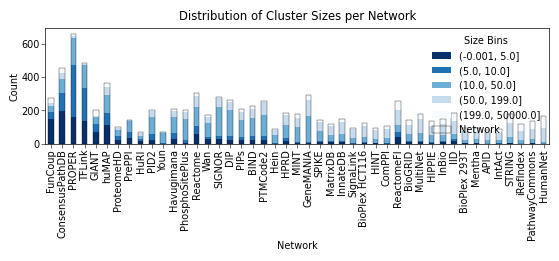

In [68]:
_ = plt.figure(figsize=(6.5, 1.5))
order = complex_df.groupby('Network').Cluster_size.median().sort_values().index.tolist()
plot_stacked_bar(complex_df, [0, 5,10, 50, 199, 50000, 100000], ax=plt.gca(), order=order)
plt.savefig(os.path.join(figdir, 'FigEV4E_complex_pred_sizes.jpg'), dpi=400, bbox_inches='tight')


### EV4F-H - Assessment of hierarchical communities

For implementation of HiDeF, see `Supplemental_Code/HiDeF_README.md`
#### Example Analysis

Here we examine the precomputed hierarchy for DIP. Note that the HiDeF algorithm is not deterministic so slight variation is expected between repeated runs.

In [69]:
dip_communities = pd.read_csv(os.path.join(gitdir, 'Data/example_outputs/ComplexPrediction', 'dip.10.nodes'), sep='\t', header=None,
                             names=['ClusterID', 'Size', 'Genes', 'Persistence' ])

Community Sizes

Text(0, 0.5, 'Community count')

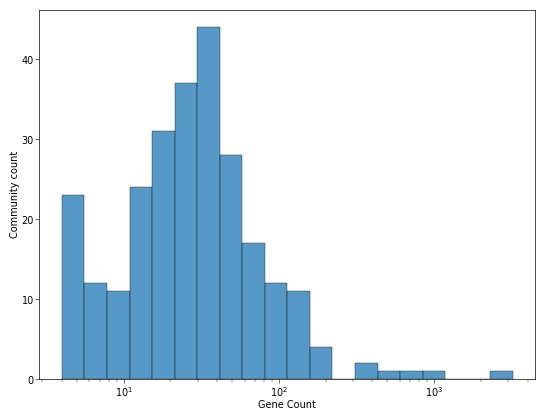

In [70]:
sns.histplot(dip_communities['Size'], bins=20, log_scale=True)
plt.xlabel('Gene Count')
plt.ylabel('Community count')

CORUM overlap

In [71]:
corum_file = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigEV4F_corum_complexes.txt')

In [72]:
# Perform the analysis
corum_analysis_wrapper(corum_file, 'dip.10', os.path.join(gitdir, 'Data/example_outputs/ComplexPrediction'))

In [73]:
# Load the results
pref='dip'
corum_to_test = pd.read_csv(os.path.join(gitdir, f'Data/example_outputs/ComplexPrediction/{pref}.10.corum_to_test.tsv'), sep='\t', index_col=0)

In [74]:
# Identify CORUM complexes with at least one community with J >= 0.5
corum_to_test[corum_to_test.J >= 0.5].shape

(43, 5)

Calculate GO Homogeneity for clusters with < 20 genes

In [75]:
gd, godag, go_branches = load_go_data()

/cellar/users/snwright/anaconda3/envs/neteval021_py311/lib/python3.11/site-packages/neteval/community_annotation.py:111: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('gene2go', sep='\t', names=['TaxID', 'GeneID', 'GO_term', 'Evidence', 'Qualifier', 'GO_name', 'Pubmed', 'Category'])


go.obo: fmt(1.2) rel(2024-06-17) 45,494 Terms


In [76]:
all_comms = dip_communities.set_index('ClusterID').Genes.to_dict()
all_comms = {k: [int(x) for x in v.split(' ') if x.isnumeric()] for k, v in all_comms.items()}

In [77]:

sub_comms = {k: v for k, v in all_comms.items() if len(v) < 20}
homogs = calculate_homogeneity(sub_comms, gd, godag, go_branches)

100%|██████████| 93/93 [00:22<00:00,  4.18it/s]


Text(0, 0.5, 'Community count')

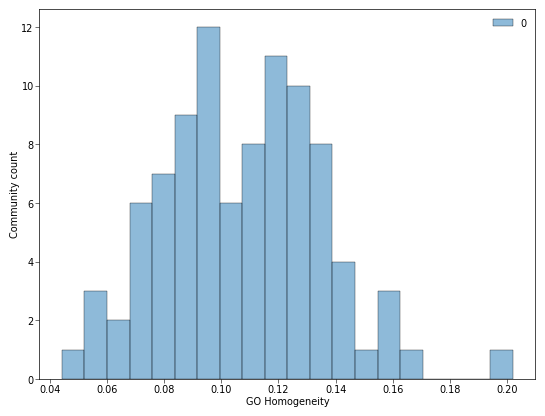

In [78]:
sns.histplot(homogs.values(), bins=20)
plt.xlabel('GO Homogeneity')
plt.ylabel('Community count')

Clustering Coefficient

In [79]:
G = load_edgelist_to_networkx(os.path.join(gitdir, 'Data/example_outputs','dip_net.txt'), id_type="Entrez", testmode=False, timer=None, delimiter="\t", node_cols=[0,1],keep_attributes=False, verbose=False)

In [80]:
coeffs = calculate_clustering_coefficient(G, all_comms)

Text(0, 0.5, 'Community count')

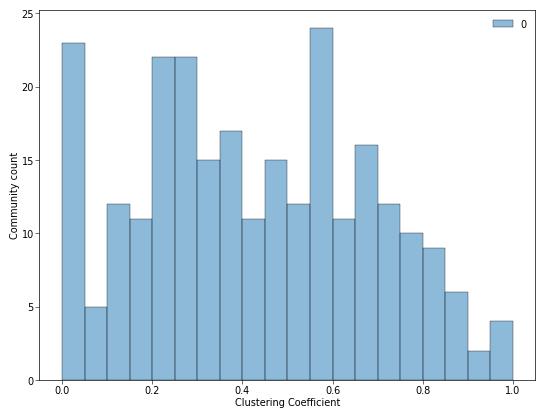

In [81]:
sns.histplot(coeffs.values(), bins=20)
plt.xlabel('Clustering Coefficient')
plt.ylabel('Community count')

#### Full Figure

In [82]:
network_classes = load_network_names(os.path.join(gitdir, "StateOfTheInteractomes_Notebooks/Data/network_classifications.txt"))

Assess evaluation metrics for complexes with < 200 genes

In [83]:
complex_df['Class'] = complex_df.Network.map(network_classes)
complex_df_small = complex_df[complex_df.Cluster_size < 200]

In [84]:
corum_ranks = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig6F_corum_complex_results.csv'), index_col=0)
corum_ranks['CORUMRank'] = corum_ranks['#CORUM Recovered'].rank(ascending=False)
corum_ranks['Network'] = corum_ranks.index

In [85]:
go_ranks = pd.DataFrame({'go_score': complex_df_small.groupby('Network').Homogeneity.mean().sort_values(ascending=False)})
go_ranks.index.name = None
go_ranks['GORank'] = go_ranks['go_score'].rank(ascending=False)
top_go = [x for x in go_ranks[0:15].index.values]

In [86]:
coeff_ranks = pd.DataFrame({'coeff': complex_df_small.groupby('Network').ClusteringCoeff.mean().sort_values(ascending=False)})
coeff_ranks.index.name = None
coeff_ranks['CoeffRank'] = coeff_ranks['coeff'].rank(ascending=False)
top_coeff = [x for x in coeff_ranks[0:15].index.values]

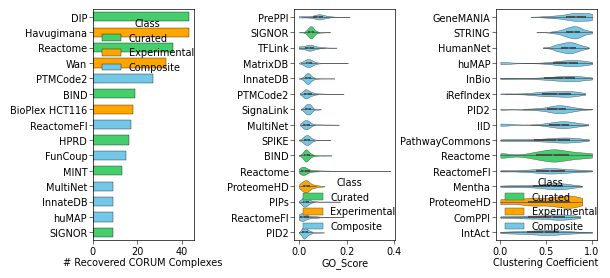

In [87]:
corum_ranks['Class'] = corum_ranks.index.map(network_classes)
_, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 3), gridspec_kw={'wspace':1})
sns.barplot(corum_ranks.iloc[0:15], x='#CORUM Recovered',y='Network', ax=ax1, hue='Class', saturation=1,
           palette=['#44cf6c', '#ffa500', '#73c7e7'], hue_order=['Curated', 'Experimental', 'Composite'],
           edgecolor='black', width=0.6)
sns.violinplot(complex_df_small[complex_df_small.Network.isin(top_go)], x='Homogeneity', y='Network', hue='Class', 
               palette=['#44cf6c', '#ffa500', '#73c7e7'], hue_order=['Curated', 'Experimental', 'Composite'], 
               saturation=1, ax=ax2, cut=0, order=top_go)
sns.violinplot(complex_df_small[complex_df_small.Network.isin(top_coeff)], x='ClusteringCoeff', y='Network', hue='Class', 
               palette=['#44cf6c', '#ffa500', '#73c7e7'], hue_order=['Curated', 'Experimental', 'Composite'],
               saturation=1, ax=ax3, cut=0, order=top_coeff)
ax1.set_xlabel("# Recovered CORUM Complexes")
ax2.set_xlabel("GO_Score")
ax3.set_xlabel("Clustering Coefficient")
for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('')
plt.savefig(os.path.join(figdir, 'FigEV4FGH_complex_pred_stats.jpg'), dpi=400, bbox_inches='tight')